In [1]:
import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

In [2]:
from scipy.stats import norm, t
import torch
import MI
import marginal as mg
import bvcopula
from vine import CVine
import pickle as pkl
from train import conf
import select_copula
import utils

import matplotlib.pyplot as plt
import numpy as np

NSamp=10000
device = torch.device('cuda:1')
x = torch.linspace(0.,1.,NSamp).numpy()
train_x = torch.tensor(x).float().to(device=device)

In [46]:
Nvar=2
rhos = np.ones(NSamp)*0.7
dfs = np.exp(5*np.linspace(0,1,NSamp))+1

HRgS = utils.student_H(rhos,dfs,Nvar)/np.log(2)
HRgS.mean()

0.5067255537165143

In [41]:
utils.student_H(rhos[0],1e10,Nvar)/np.log(2)

2.5109975203922317

In [42]:
from scipy.stats import sem as SEM

In [55]:
sem = float("inf")
HRS,HR, var_sum, k = 0,0,0,0
N = 1
while sem>0.01:
    samples = utils.student_rvs(Nvar,rhos,dfs,N)
    samples = np.einsum("ij...->ji...",samples)
    log_probs = utils.student_logprob(samples,rhos,dfs)
    Hrs = log_probs.mean(axis=-1)
    Hr = np.zeros((10000,N,NSamp))
    for l in range(10000):
        perm = np.random.permutation(np.arange(len(rhos)))
        Hr[l] = np.exp(utils.student_logprob(samples,rhos[perm],dfs[perm]))
    err = SEM(Hr,axis=0).max(axis=-1)
    Hr = np.log(Hr.mean(axis=0)).mean(axis=-1)
    
    print(Hrs.mean(),Hr.mean())
    
    k+=1
    HR += (Hr.mean()-HR)/k
    HRS += (Hrs.mean()-HRS)/k
    var_sum += ((Hr-HR)**2).sum() + ((Hrs-HRS)**2).sum() + ((err/np.exp(Hr))**2).sum()
    sem = norm.ppf(1 - 0.05) * (var_sum / (k * N * (k * N - 1)))**(.5)
    print(HRS-HR,sem)

-2.777525721382857 -2.8035855011058697
0.026059779723012877 inf


/home/nina/.envs/GPyTorch_new/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


-2.7686392397164408 -2.79714514012067
0.02728284006362136 0.007022649273546878


In [31]:
y = utils.student_rvs(Nvar,rhos,dfs,1).squeeze()
y0 = np.zeros_like(y)
for i in range(y.shape[0]):
    y0[i] = t.cdf(y[i],df=dfs[i])

In [32]:
KSG = mg.revised_mi(x.reshape((*x.shape,1)),y0,)
KSG

(0.009120063293994713, -2.590284314602333)

In [33]:
N = Nvar
#redirect logging here
exp_pref='benchmark'
data_layers = [torch.tensor(y0).float().to(device)]
copula_layers = []
for m in range(0,N-1):
    out_dir = f'{conf.path2outputs}/{exp_pref}/layer{m}'
    copulas, layer = [], []
    for n in range(1,N-m):
        print(m,n+m)
        samples = data_layers[-1][...,[n,0]]
        waic, model = bvcopula.infer([bvcopula.GaussianCopula_Likelihood(),
                                      bvcopula.GumbelCopula_Likelihood(rotation='0°'),
                                      bvcopula.GumbelCopula_Likelihood(rotation='180°')],
                                     train_x,samples,device=device)
#         (likelihoods, waic) = select_copula.select_with_heuristics(x,samples.cpu().numpy(),device,exp_pref,out_dir,m,n+m,
#                                                                   train_x=train_x, train_y=samples)
#         weights_file = f"{out_dir}/model_{exp_pref}_{m}-{m+n}.pth"
#         model = utils.get_model(weights_file, likelihoods, device) 
        with torch.no_grad():
            f = model(train_x).mean
            copula = model.likelihood.get_copula(f)
            copulas.append(copula)
            layer.append(copula.ccdf(samples))
    data_layers.append(torch.stack(layer,dim=-1))
    copula_layers.append(copulas)

0 1
0 2
1 2


In [34]:
vine_trained = CVine(copula_layers,train_x,device=device)
# with open(f"{home}vine.pkl","wb") as f:
#     pkl.dump([y,vine_trained],f)

In [35]:
# with open(f"{home}vine.pkl","rb") as f:
#     [y0,vine_trained] = pkl.load(f)

In [36]:
subvine = vine_trained.create_subvine(torch.arange(0,NSamp,50))
%time CopulaGP = subvine.stimMI(sem_tol=0.01)

CopulaGP

CPU times: user 7.56 s, sys: 6.93 s, total: 14.5 s
Wall time: 2.89 s


(tensor([0.0198], device='cuda:1'),
 tensor(0.0139, device='cuda:1'),
 tensor([2.5988], device='cuda:1'),
 tensor(0.0098, device='cuda:1'))

In [58]:
results_file = f"{home}/MI_dump.pkl"
with open(results_file,'rb') as f:
    results = pkl.load(f)  
i = list(range(len(results)))
for k in range(3):
    i[3+k]=6+k
    i[6+k]=3+k
results = [results[j] for j in i]
results[0]

[[2, 10000],
 [0.5067255537165143, 0.4864134192466736, 0.42834700404217757],
 [0.04297121571048656,
  0.011314034461975098,
  -0.012989229121354083,
  -0.00630323777436247],
 [array([[0.82482911, 0.50218122],
         [0.44185201, 0.54418388],
         [0.22750769, 0.13326953],
         ...,
         [0.03646357, 0.02781185],
         [0.44690433, 0.06313422],
         [0.03237183, 0.11144026]]),
  array([0.7, 0.7, 0.7, ..., 0.7, 0.7, 0.7]),
  array([  2.        ,   2.00050018,   2.0010006 , ..., 149.2648053 ,
         149.33896365, 149.4131591 ])]]

In [59]:
Ns = np.array([res[0][0] for res in results])
Ns

array([ 2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  4,  4,  4,  5,  5,
        5,  6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10])

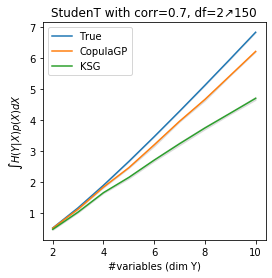

In [60]:
plt.figure(figsize=(4,4))
def line(H,label,cut=Ns.max()):
    NN = cut+1-Ns.min()
    A = np.empty((3,NN))
    for i in range(NN):
        n = Ns.min()+i
        A[0,i] = n
        A[1,i] = H[Ns==n].mean()
        A[2,i] = H[Ns==n].std()
    plt.plot(A[0],A[1],label=label)
    plt.fill_between(A[0],A[1]-A[2],A[1]+A[2],color='grey',alpha=0.2)
for i,label in enumerate(["True","CopulaGP","KSG"]):
    line(np.array([res[1][i] for res in results]),label)
plt.title("StudenT with corr=0.7, df=2↗150")
plt.xlabel("#variables (dim Y)")
plt.ylabel("$\int H(Y|X)p(X)dX$")
plt.legend();

In [25]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

def train_MINE(train, H=100, lr=0.01, rep=10, n_epoch=2000, device = torch.device("cuda:1")):

    data_size = train.shape[0]
    
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(1, H)
            self.fc2 = nn.Linear(train.shape[-1], H)
            self.fc3 = nn.Linear(H, 1)

        def forward(self, x, y):
            h1 = F.relu(self.fc1(x)+self.fc2(y))
            h2 = self.fc3(h1)
            return h2  
    
    model = Net().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    plot_loss, plot_test = [], []
    x_sample = Variable(torch.cat(rep*[torch.linspace(0.,1.,data_size).unsqueeze(-1).to(device)]), 
                        requires_grad = True)   
    y_train = Variable(torch.cat(rep*[torch.from_numpy(train).type(torch.FloatTensor).to(device)]), 
                       requires_grad = True)
    for epoch in range(n_epoch):
        y_shuffle = y_train[torch.cat([torch.randperm(data_size) for _ in range(rep)])]

        pred_xy = model(x_sample, y_train)
        pred_x_y = model(x_sample, y_shuffle)

        ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        loss = - ret  # maximize
        plot_loss.append(-loss.data.cpu().numpy())
        model.zero_grad()
        loss.backward()
        optimizer.step()
    return plot_loss

In [34]:
%time plot_loss = train_MINE(results[-1][-1][0])
plt.plot(-plot_loss)
print(np.mean(plot_loss[-50:]),np.std(plot_loss[-50:]))

CPU times: user 8.43 s, sys: 8.25 s, total: 16.7 s
Wall time: 16.5 s


TypeError: bad operand type for unary -: 'list'

In [62]:
import tqdm
import MI
MINEs = []
for res in tqdm.tqdm(results):
    MINEs.append(MI.train_MINE(res[-1][0],H=100,lr=0.01))
MINE100 = MINEs

100%|██████████| 33/33 [11:45<00:00, 21.39s/it]


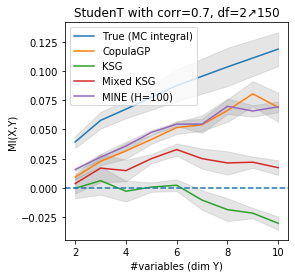

In [193]:
plt.figure(figsize=(4,4))

plt.plot(true[0],true[1][:,0],label="True (MC integral)")
plt.fill_between(true[0],true[1][:,0]-true[1][:,1]/2,true[1][:,0]+true[1][:,1]/2,color='grey',alpha=0.2)

for i,label in enumerate(["Direct MC","CopulaGP","KSG","Mixed KSG"]):
    if i>0:
        k=1
        if i==3:
            k=np.log(2)
        line(np.array([res[2][i]/k for res in results]),label)
# line(np.array(MINEs20)/np.log(2),"MINE (H=20)")
# line(np.array(MINEs50)/np.log(2),"MINE (H=50)")
line(np.array(MINE100)/np.log(2),"MINE (H=100)")
# line(np.array(MINE1000)/np.log(2),"MINE (H=1000)")
plt.axhline(0,linestyle='dashed')
plt.title("StudenT with corr=0.7, df=2↗150")
plt.xlabel("#variables (dim Y)")
plt.ylabel("MI(X,Y)")
plt.legend(loc=2);

In [174]:

# %time plot_loss=train()

In [188]:
true = [[2,3,4,6,8,10],\
        np.array([[0.02728,0.00702],[0.04005,0.00984],[0.04672,0.01081],\
                  [0.06067,0.03751],[0.07172, 0.02266],[0.08226,0.04006]])/np.log(2)]

In [132]:
samples = utils.student_rvs(6,np.array([0.7]),np.array([2]),1000).squeeze()

In [104]:
(samples.min(axis=0),samples.max(axis=0))

(array([-21.97171935, -20.21348566]), array([36.57134085, 35.62023133]))

In [174]:
from scipy.special import beta, gamma, digamma
def det(rho,n):
    return ((n-1)*rho + 1)*(1-rho)**(n-1)

def student_logprob(t,rho,df):
    n = t.shape[-1]
    D = det(rho,n)
    cov = np.ones(n)*rho + (1-rho)*np.identity(n)
    tSt = np.dot(np.dot(t.T,np.linalg.inv(cov)),t)
    print(n,tSt)
    tSt = (rho * (t.sum(axis=-1))**2 - (1+(n-1)*rho)*(t**2).sum(axis=-1) )/ ((n-1)*rho**2 - (n-2)*rho-1)
    print(rho,tSt)
    #devide by almost D, except that (1-rho)**1, not (1-rho)**(n-1)
    C = np.log(gamma(n/2)) - np.log(beta(df/2,n/2)) - 0.5*(n*np.log(np.pi*df)+np.log(np.abs(D)))
    return C - ((df+n)/2) * np.log(1 + tSt/df)

In [179]:
student_logprob(samples[10],-0.7,10)

6 -0.2780649374971466
-0.7 -0.27806493749714595


-6.553950088755908

In [135]:
samples[10]

array([0.35798917, 0.68929811, 0.65505537, 0.12992413, 0.17532224,
       0.92346463])

In [162]:
418/60

6.966666666666667